[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/image-retrieval/color-histograms/01-search-histogram.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/image-retrieval/color-histograms/01-search-histogram.ipynb)

# Color Histogram Embedding and Search

Let's take what we've learned in the previous notebook about building color histograms and apply it to create image embeddings and use them in search.

First we load the images from HuggingFace *Datasets*.

In [1]:
from datasets import load_dataset
from base64 import b64decode
import cv2
import numpy as np

data = load_dataset('pinecone/image-set', split='train')

def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

images = [process_fn(sample) for sample in data]

Using custom data configuration pinecone--image-set-1df6f139371b1cf6
Reusing dataset json (/Users/jamesbriggs/.cache/huggingface/datasets/pinecone___json/pinecone--image-set-1df6f139371b1cf6/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)


We will create a function to build the RGB histograms and transform them into a single vector. The reason we use a vector is because we can compare vectors using metrics like Euclidean distance or cosine similarity.

In [2]:
def get_vector(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

In [3]:
vec = get_vector(images[0])
vec.shape

(96,)

Now we have a single vector representation of our image color histograms, values [0, ..., 32] are red, [32, ..., 64] are green, and [64, ..., 96] are blue.

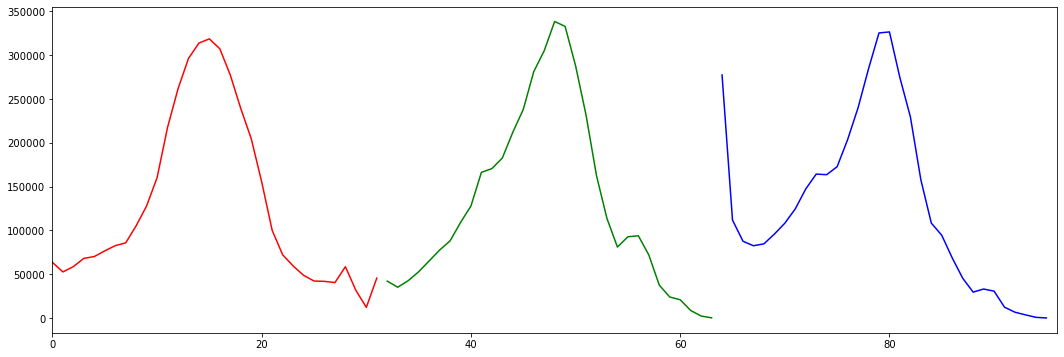

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.plot(list(range(32)), vec[:32], color='red')
plt.plot(list(range(32, 64)), vec[32:64], color='green')
plt.plot(list(range(64, 96)), vec[64:96], color='blue')

plt.xlim(0, 96)

plt.show()

Let's do this for the remainder of our images.

In [5]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image))

Now we can compare vectors with Euclidean distance, calculated with Numpy like so:

In [6]:
dist = np.linalg.norm(image_vectors[0] - image_vectors[1])
dist

2007399.9

Or using cosine similarity, as shown in the `cosine` function below:

In [7]:
def euclidean(a, b):
    return np.linalg.norm(a - b)
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

We use this to find the most similar matches for each image, we'll do this within a function to keep everything clean.

In [8]:
# during visualization we use this array of RGB images
rgb_images = np.array([np.flip(image, 2) for image in images])

def search(idx, top_k=5):
    query_vector = image_vectors[idx]
    distances = []
    for _, vector in enumerate(image_vectors):
        distances.append(cosine(query_vector, vector))
    # get top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return top_idx

/var/folders/g7/qd2j76kn64ggrl4ym2vlvzwr0000gn/T/ipykernel_61913/3508758223.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgb_images = np.array([np.flip(image, 2) for image in images])


In [9]:
search(0)

array([ 3, 18, 14, 15,  0])

Let's write another function to help us visualize these results.

In [10]:
def visualize(query_i, results_i):
    query = rgb_images[query_i]
    span = int(len(image_vectors[0])/3)
    results = rgb_images[results_i]
    top_k = len(results)
    # visualize query image and it's color histogram
    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    axs[0].imshow(query)
    axs[0].axis('off')
    axs[1].plot(image_vectors[query_i][:span], 'r', label='red')
    axs[1].plot(image_vectors[query_i][span:span*2], 'g', label='green')
    axs[1].plot(image_vectors[query_i][span*2:], 'b', label='blue')
    plt.show()
    # visualize top k images and their color histograms
    fig0, axs0 = plt.subplots(1, top_k, figsize=(top_k*5, 5))
    fig1, axs1 = plt.subplots(1, top_k, figsize=(top_k*5, 5), sharey=True)
    for i in range(top_k):
        axs0[i].imshow(results[i])
        axs0[i].axis('off')
        axs1[i].plot(image_vectors[results_i[i]][:span], 'r', label='red')
        axs1[i].plot(image_vectors[results_i[i]][span:span*2], 'g', label='green')
        axs1[i].plot(image_vectors[results_i[i]][span*2:], 'b', label='blue')

In [11]:
results_i = search(0)

In [12]:
results_i

array([ 3, 18, 14, 15,  0])

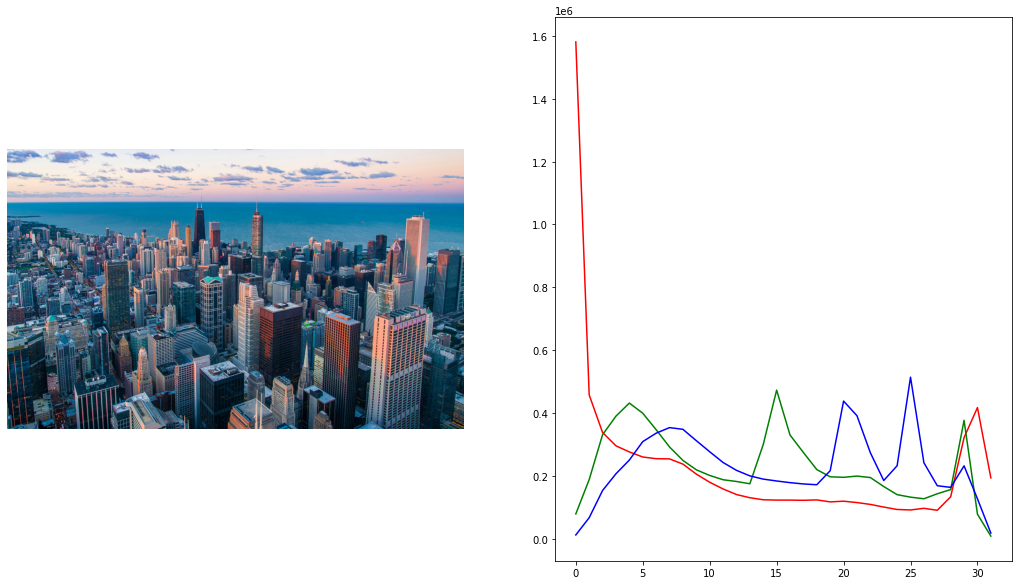

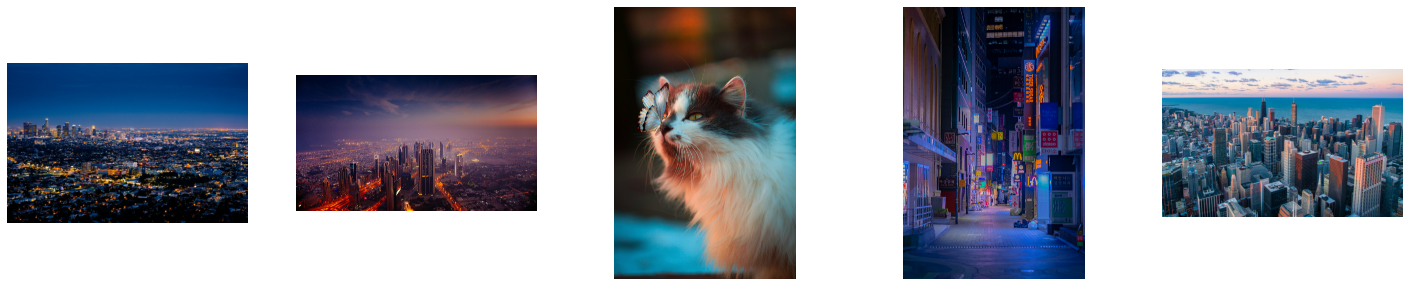

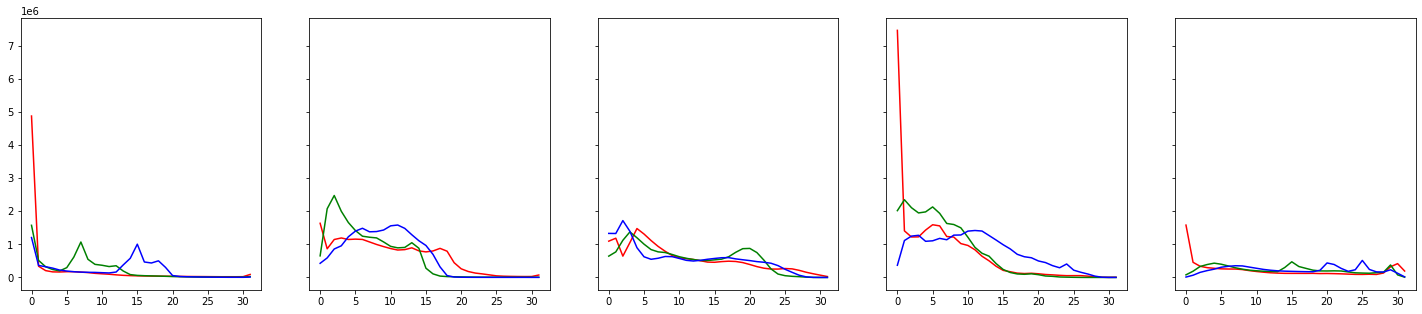

In [13]:
img = 6
visualize(img, search(img))

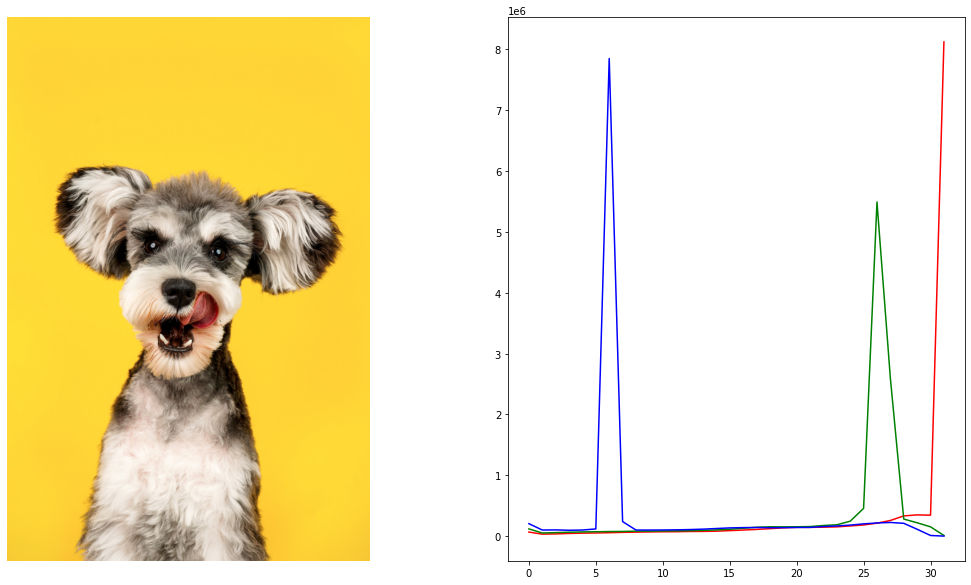

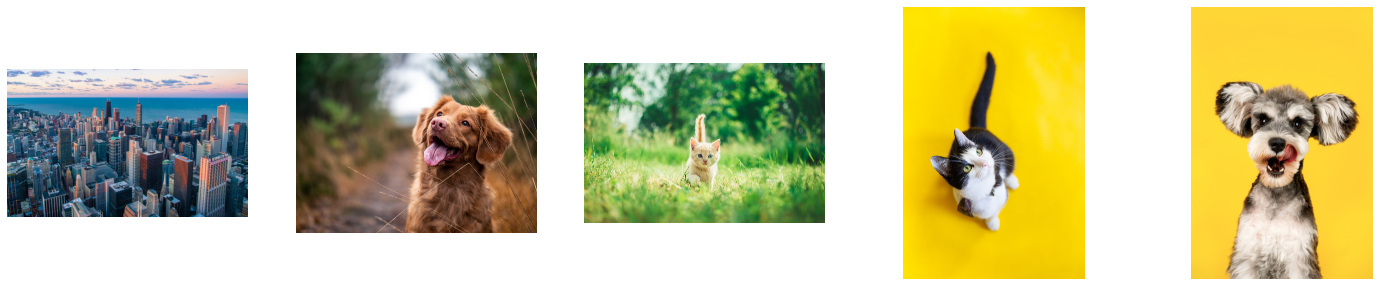

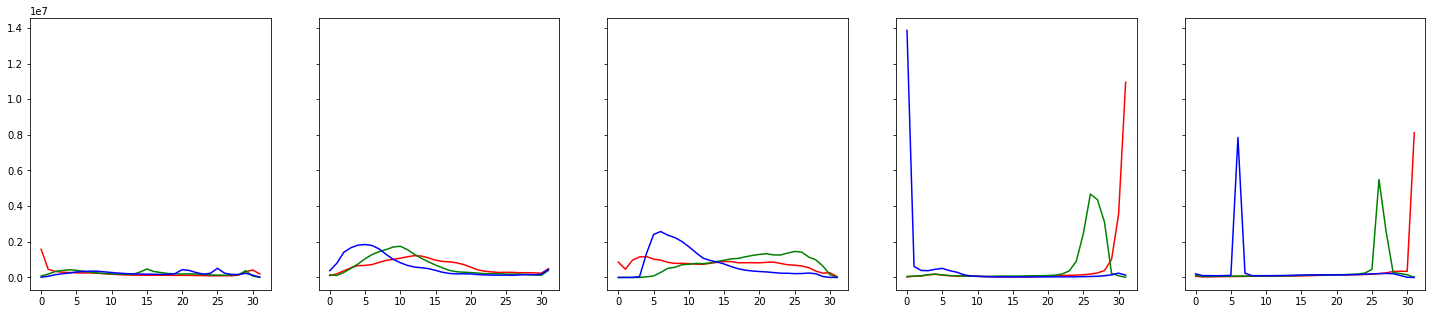

In [14]:
img = 10
visualize(img, search(img))

Let's see the effect of modifying the number of bins.

In [15]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image, bins=96))

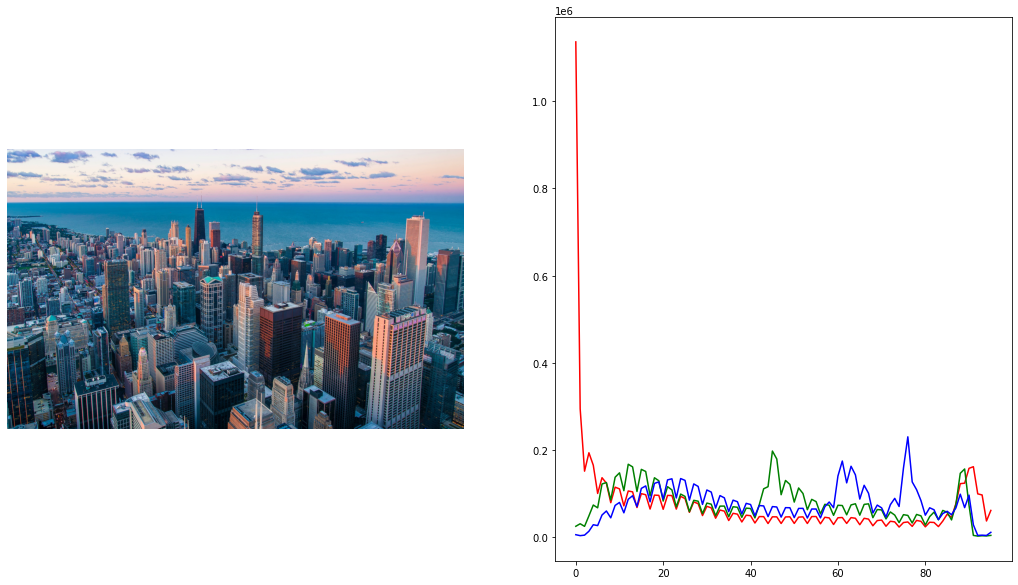

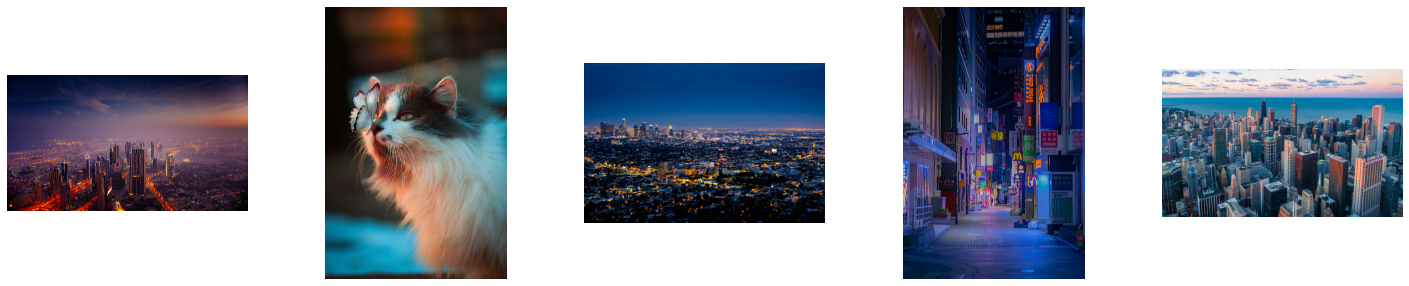

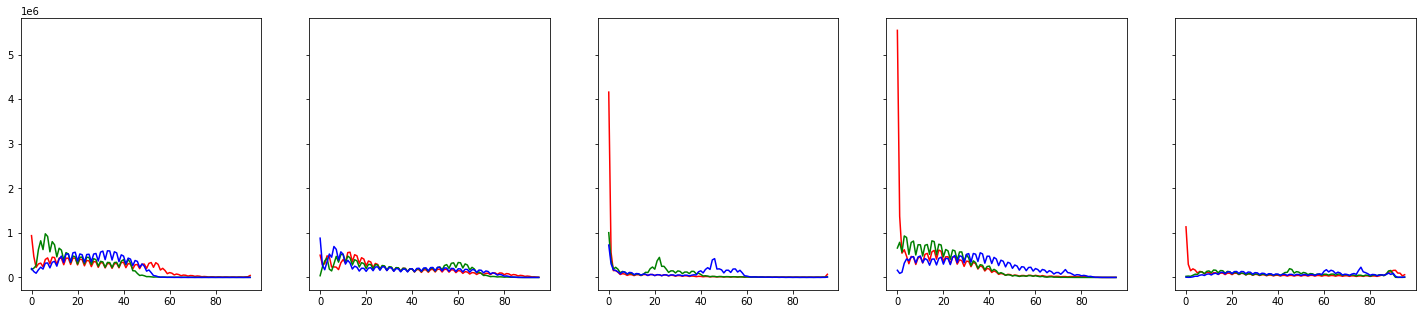

In [16]:
img = 6
visualize(img, search(img))

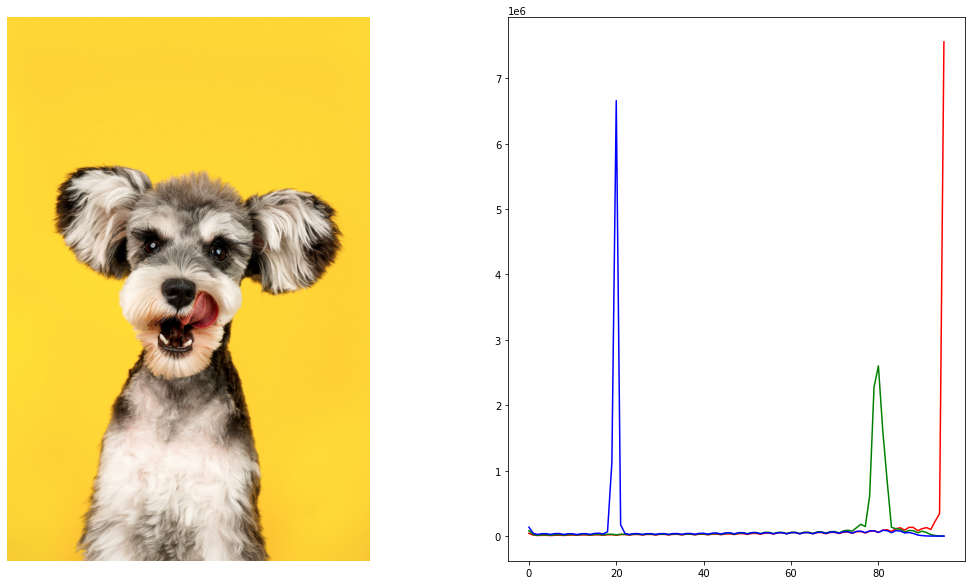

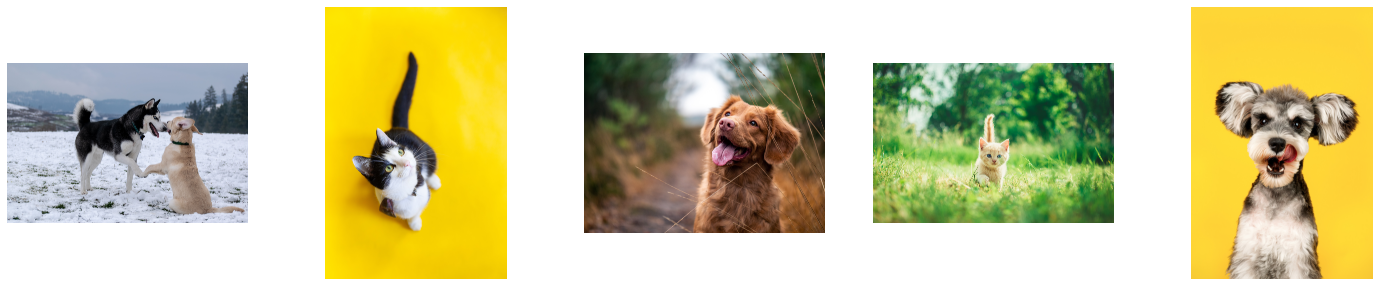

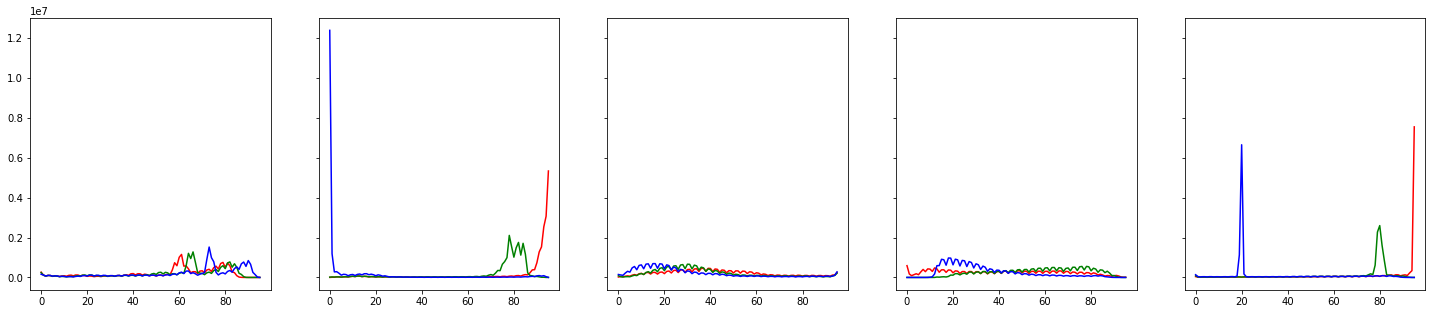

In [17]:
img = 10
visualize(img, search(img))

In [18]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image, bins=256))

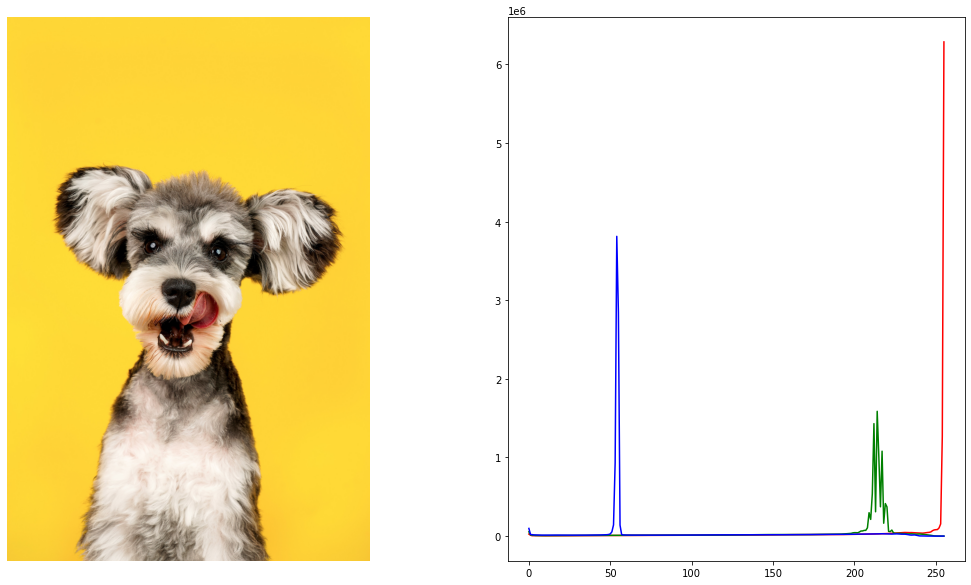

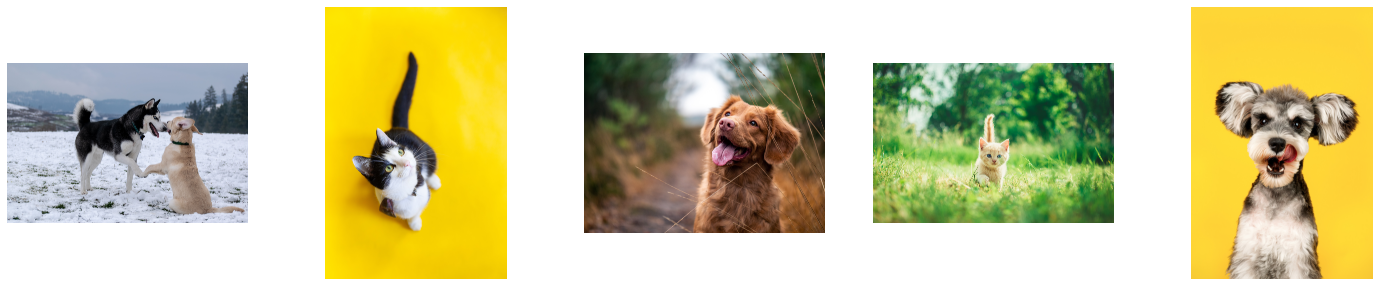

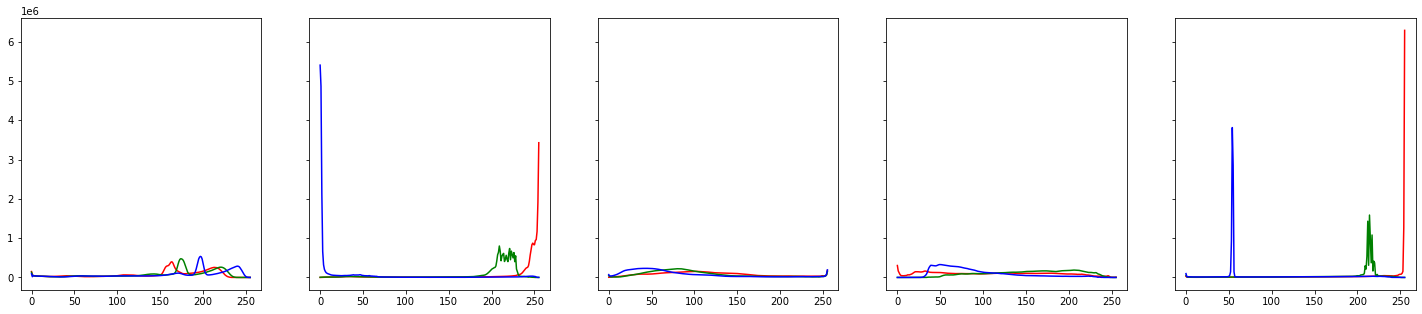

In [19]:
img = 10
visualize(img, search(img))